In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
X,y_hr,y_participant,y_activity = pickle.load(open('../data/heart_rate_tabular_data_ppg_dalia.p','rb'))
activity_dict1 = {'No Label':-1,'Sitting':0,'Stairs':1,'Soccer':2,
                'Cycling':3,'Driving':4,'Lunch':-1,'Walking':5,
                'Working':-1}
y_activity = np.array([activity_dict1[a] for a in y_activity])
X = X[:,:,1:].reshape(-1,256,3)
X = X[y_activity==5]
min1,max1 = np.min(X),np.max(X)
cc = np.max(np.abs(X))
X = X/cc
# X = X/np.max(X)
y_activity = OneHotEncoder().fit_transform(y_activity.reshape(-1,1)).todense()
activity_dict_reverse = {activity_dict1[key]:key for key in activity_dict1.keys()}

In [2]:
# for a in X:
#     plt.figure(figsize=(5,3))
#     plt.plot(a*cc)
#     plt.ylim([min1, max1])
#     plt.show()

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
def conv_block(x,filters,activation,kernel_size=(3, 3),strides=(1, 1),
               padding="same",use_bias=True,use_bn=False,
               use_dropout=False,drop_value=0.5):
    
    x = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model(input_shape = (256,3)):
    
    input_ = layers.Input(shape=input_shape)
    
    x = conv_block(input_,64,kernel_size=20,strides=2,use_bn=False,use_bias=True,
        activation=layers.LeakyReLU(0.2),use_dropout=False,drop_value=0.3)
    
    x = conv_block(x,128,kernel_size=10,strides=2,use_bn=False,activation=layers.LeakyReLU(0.2),
        use_bias=True,use_dropout=True,drop_value=0.3)
    
    x = conv_block(x,128,kernel_size=10,strides=2,use_bn=False,
        activation=layers.LeakyReLU(0.2),use_bias=True,use_dropout=True,drop_value=0.3)
    
    x = conv_block(x,128,kernel_size=10,strides=2,use_bn=False,
        activation=layers.LeakyReLU(0.2),use_bias=True,use_dropout=True,drop_value=0.3)
    
    x = layers.Flatten()(x)
    
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(input_, x, name="discriminator")
    
    return d_model


d_model = get_discriminator_model(input_shape=(256,3))
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 64)           3904      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 128)           82048     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)         

In [5]:
def upsample_block(x,filters,activation,kernel_size=20, strides=1, up_size=2, 
                    padding="same",use_bn=False,use_bias=True,
                    use_dropout=False,drop_value=0.3):
    
    x = layers.UpSampling1D(up_size)(x)
    
    x = layers.Conv1D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
        
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    
    return x


def get_generator_model(latent_size=100,first_dense_shape=128):
    noise = layers.Input(shape=(latent_size,))
    
    x = layers.Dense(first_dense_shape, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((128,1))(x)
    
    
    x = upsample_block(x,128, layers.LeakyReLU(0.2), strides=1, use_bias=False,
                       use_bn=True, padding="same", use_dropout=False)
    
    x = upsample_block(x, 64, layers.LeakyReLU(0.2), strides=1, use_bias=False,
                       use_bn=True, padding="same", use_dropout=False)
    
    x = conv_block(x,64,kernel_size=40,strides=2,use_bn=False,use_bias=True,
                   activation=layers.LeakyReLU(0.2),use_dropout=False,drop_value=0.3)
    
    x = conv_block(x,3,kernel_size=20,strides=1,use_bn=False,use_bias=True,
                  activation=layers.Activation('tanh'),use_dropout=False,drop_value=0.3)
    
    g_model = keras.models.Model(noise, x, name="generator")
    
    
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12800     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 256, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 128)          25

In [6]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


In [7]:
import matplotlib.pyplot as plt
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        for i in range(self.num_img):
            img = generated_images[i].numpy()*cc
            
            plt.figure(figsize=(5,3))
            plt.plot(img)
#             img = keras.preprocessing.image.array_to_img(img)
            plt.ylim([min1,max1])
            plt.savefig("./images/generated_img_{i}_{epoch}.png".format(i=epoch, epoch=i))
            plt.close('all')

In [8]:
noise_dim = 100
BATCH_SIZE = 200
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 60

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
history = wgan.fit(X, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])



Epoch 1/60
24/24 [==============================] - 3s 114ms/step - d_loss: -3.9156 - g_loss: 11.2181
Epoch 2/60
24/24 [==============================] - 2s 98ms/step - d_loss: -2.4199 - g_loss: 6.3643
Epoch 3/60
24/24 [==============================] - 2s 97ms/step - d_loss: -2.1260 - g_loss: 3.6005
Epoch 4/60
24/24 [==============================] - 2s 99ms/step - d_loss: -2.5216 - g_loss: 3.1041
Epoch 5/60
24/24 [==============================] - 2s 99ms/step - d_loss: -2.6371 - g_loss: 3.3060
Epoch 6/60
24/24 [==============================] - 2s 98ms/step - d_loss: -2.5914 - g_loss: 3.2806
Epoch 7/60
24/24 [==============================] - 2s 98ms/step - d_loss: -2.4808 - g_loss: 3.1452
Epoch 8/60
24/24 [==============================] - 2s 99ms/step - d_loss: -2.3450 - g_loss: 3.2172
Epoch 9/60
24/24 [==============================] - 2s 99ms/step - d_loss: -2.0137 - g_loss: 2.8938
Epoch 10/60
24/24 [==============================] - 2s 98ms/step - d_loss: -1.8767 - g_loss: 3.23

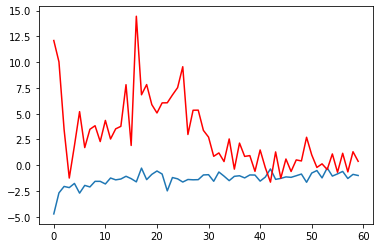

In [10]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'],'r')
